# Datasets
https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=train.csv

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
# 選擇剛剛下載好的 kaggle.json 檔案

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'shivan118/big-mart-sales-prediction-datasets'

Dataset URL: https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets
License(s): CC0-1.0
  0% 0.00/327k [00:00<?, ?B/s]
100% 327k/327k [00:00<00:00, 53.2MB/s]


In [ ]:
! mkdir BigMart-Sales-PredictionDatasets

! unzip big-mart-sales-prediction-datasets.zip -d BigMart-Sales-PredictionDatasets

Archive:  big-mart-sales-prediction-datasets.zip
  inflating: BigMart-Sales-PredictionDatasets/sample_submission.csv  
  inflating: BigMart-Sales-PredictionDatasets/test.csv  
  inflating: BigMart-Sales-PredictionDatasets/train.csv  


# Problem Statement
BigMart 的資料科學家收集了 2013 年不同城市 10 家商店 1559 種產品的銷售資料。此外，還定義了每個產品和商店的某些屬性。這個數據科學計畫的目的是建立一個預測模型並找出特定商店中每種產品的銷售量。

**Business Goal :** BigMart 將嘗試了解在增加銷售額方面發揮關鍵作用的產品和商店的屬性。

**Analysis:**

Type of problem: Supervised Learning problem

Target feature : Item_Outlet_Sales


In [ ]:
! pip install optuna

# Loading Packages and Data

In [ ]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)

In [ ]:
# loading the data
train = pd.read_csv("/content/BigMart-Sales-PredictionDatasets/train.csv")
test  = pd.read_csv( "/content/BigMart-Sales-PredictionDatasets/test.csv")

# Data Structure and Content

In [ ]:
train # 8523 rows × 12 columns

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Features Description:

**Numerical features:**

*   Item_Weight : Weight of the product or item.
*   Item_Visibility : The % of the total display area of all products in a store allocated to the particular product.
*   Item_MRP : Maximum Retail Price (list price) of the product
*   Outlet_Establishment_Year : The year in which the store was established.
*   Item_Outlet_Sales : sales of the product in a particular store. This is the target variable to be predicted.

**Categorical features:**

*   Item_Identifier : Unique product ID (we would want to drop this column later)
*   Item_Fat_Content : Whether the product is low, fat or not
*   Item_Type : The category to which the product belongs.
*   Outlet_Identifier : Unique store ID
*   Outlet_Size : The size of the store in terms of ground area covered.
*   Outlet_Location_Type : The type of city in which the store is located.
*   Outlet_Type : Whether the outlet is just a grocery store or some sort of supermarket.




In [ ]:
import missingno as msno

msno.bar(train)

Missing Value：Item_Weight、Outlet_Size

*   2410 missing values in the Outlet_Size feature which is a categorical feature.
*   1463 missing values in the Item_Weight feature



In [ ]:
train.Item_Type.value_counts()

,count
Item_Type,
Fruits and Vegetables,1232
Snack Foods,1200
Household,910
Frozen Foods,856
Dairy,682
Canned,649
Baking Goods,648
Health and Hygiene,520
Soft Drinks,445


In [ ]:
train.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [ ]:
train['Outlet_Identifier'].value_counts()

,count
Outlet_Identifier,
OUT027,935
OUT013,932
OUT049,930
OUT046,930
OUT035,930
OUT045,929
OUT018,928
OUT017,926
OUT010,555


In [ ]:
test # 5681 rows × 11 columns

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


<Axes: >

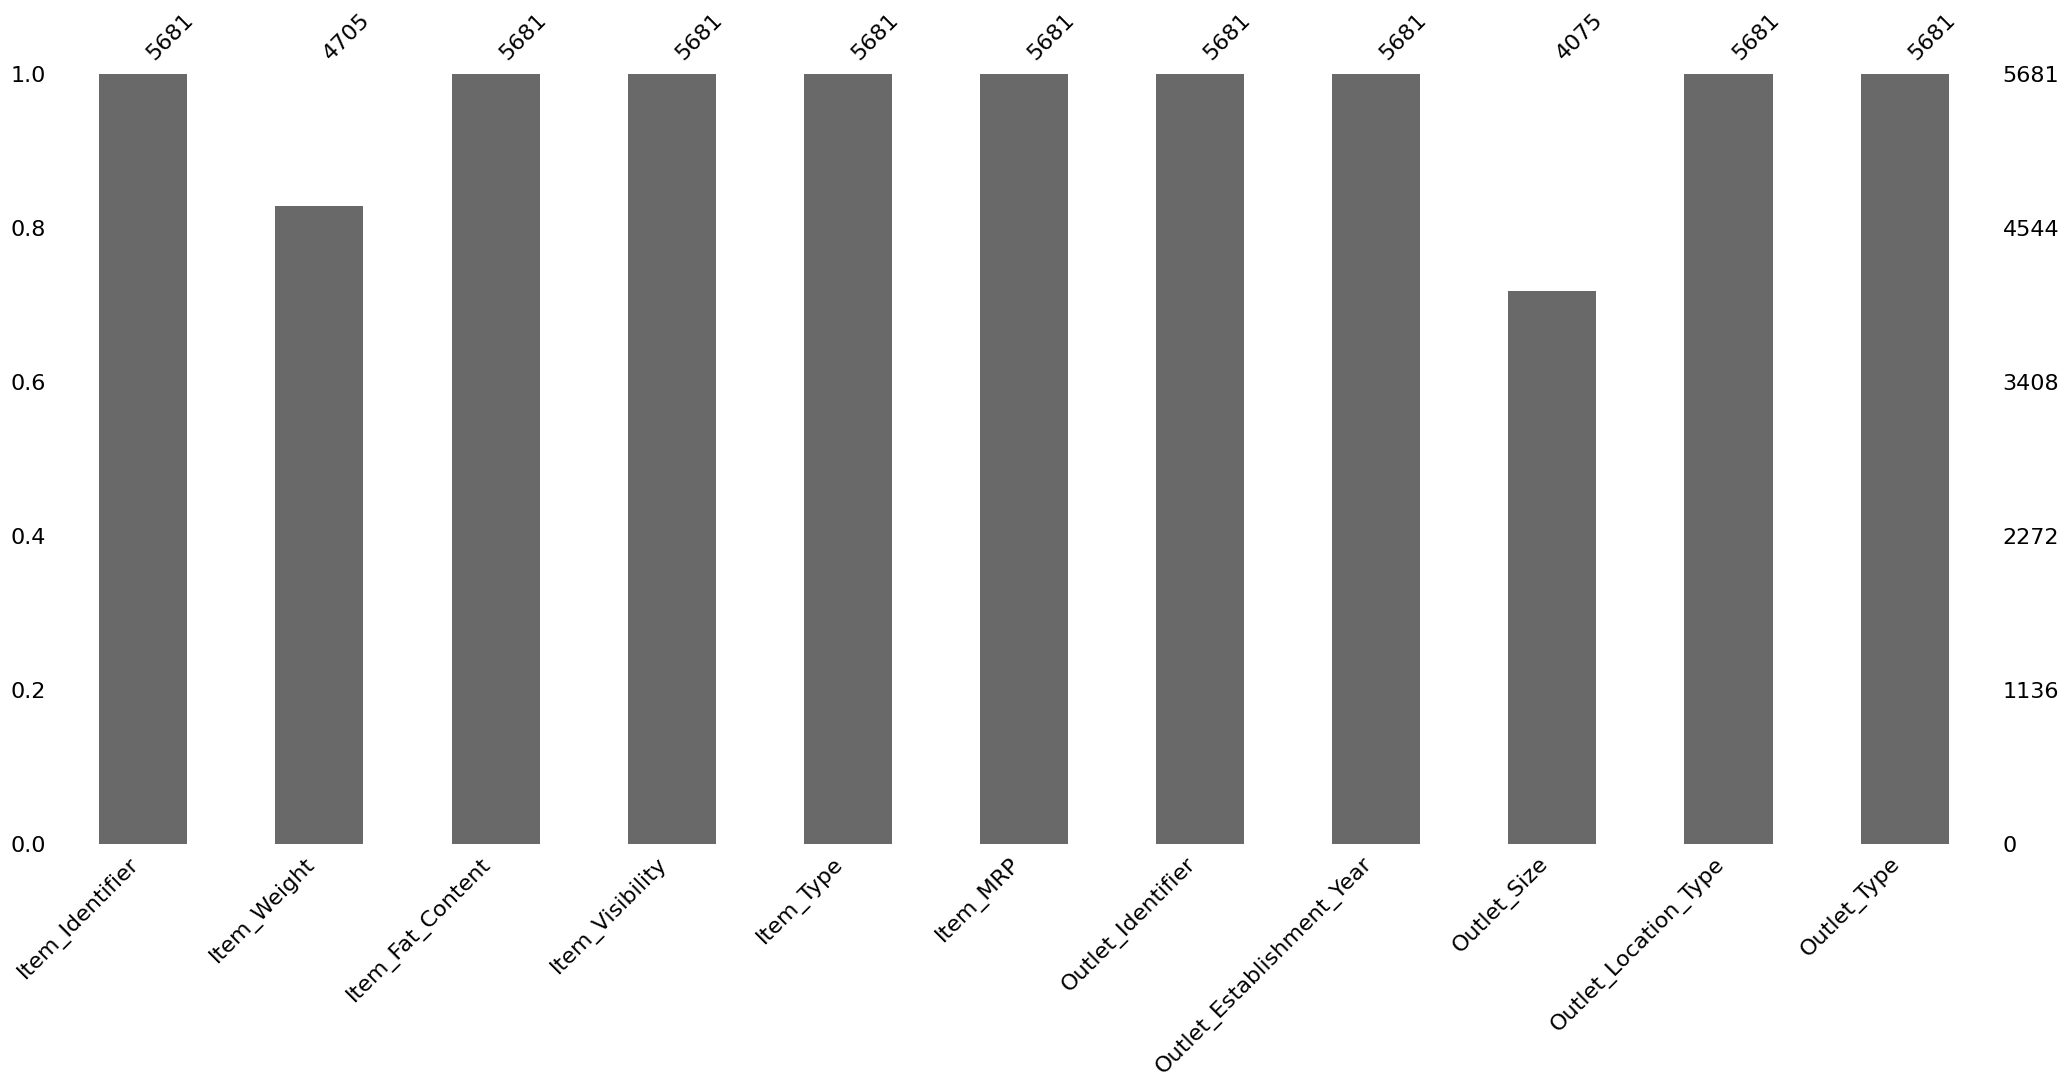

In [ ]:
msno.bar(test)

Missing Value：Item_Weight、Outlet_Size

# Exploratory Data Analysis - EDA

Numerical columns

In [ ]:
numeric_cols = train.select_dtypes(include=['float64' ,'int64']).columns
numeric_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


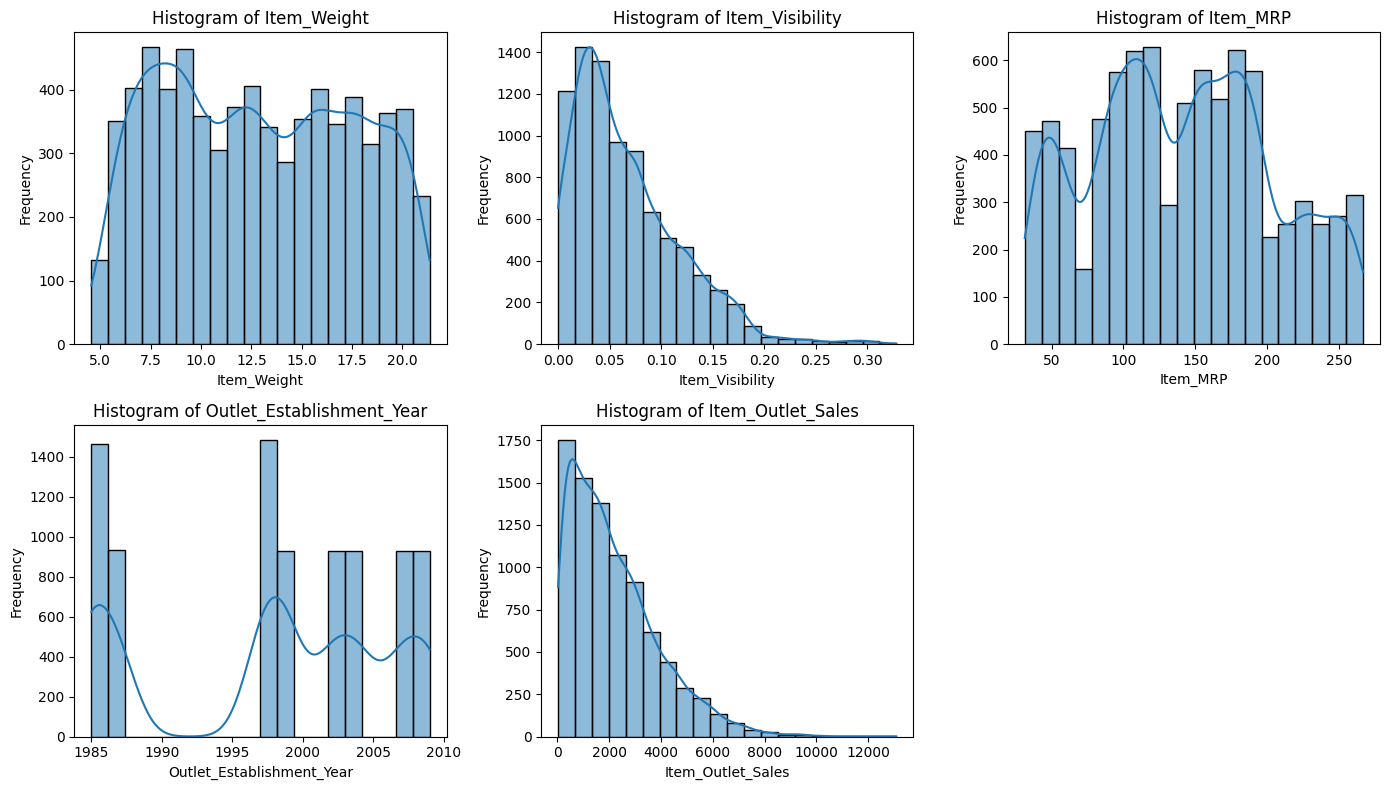

In [ ]:
plt.figure(figsize=(14 ,8))
for i ,column in enumerate(numeric_cols ,1) :
  plt.subplot(2 ,3 ,i)
  sns.histplot(train[column] ,bins=20 ,kde=True)
  plt.title(f'Histogram of {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**觀察結果：**

*   我們觀察到該物品的重量範圍為 5 公斤至 20 公斤。
*   Item_Visibility 特徵右偏。.
*   Item_MRP 功能中有更多 100 MRP - 180 MRP 範圍內的產品
*   我們可以觀察到，1985年、1998年等年間開設了許多商店……而1990年至1995年間沒有開設商店。
*   Item_Outlet_Sales 特徵右偏。我們可以嘗試進行變換以獲得常態或高斯分佈






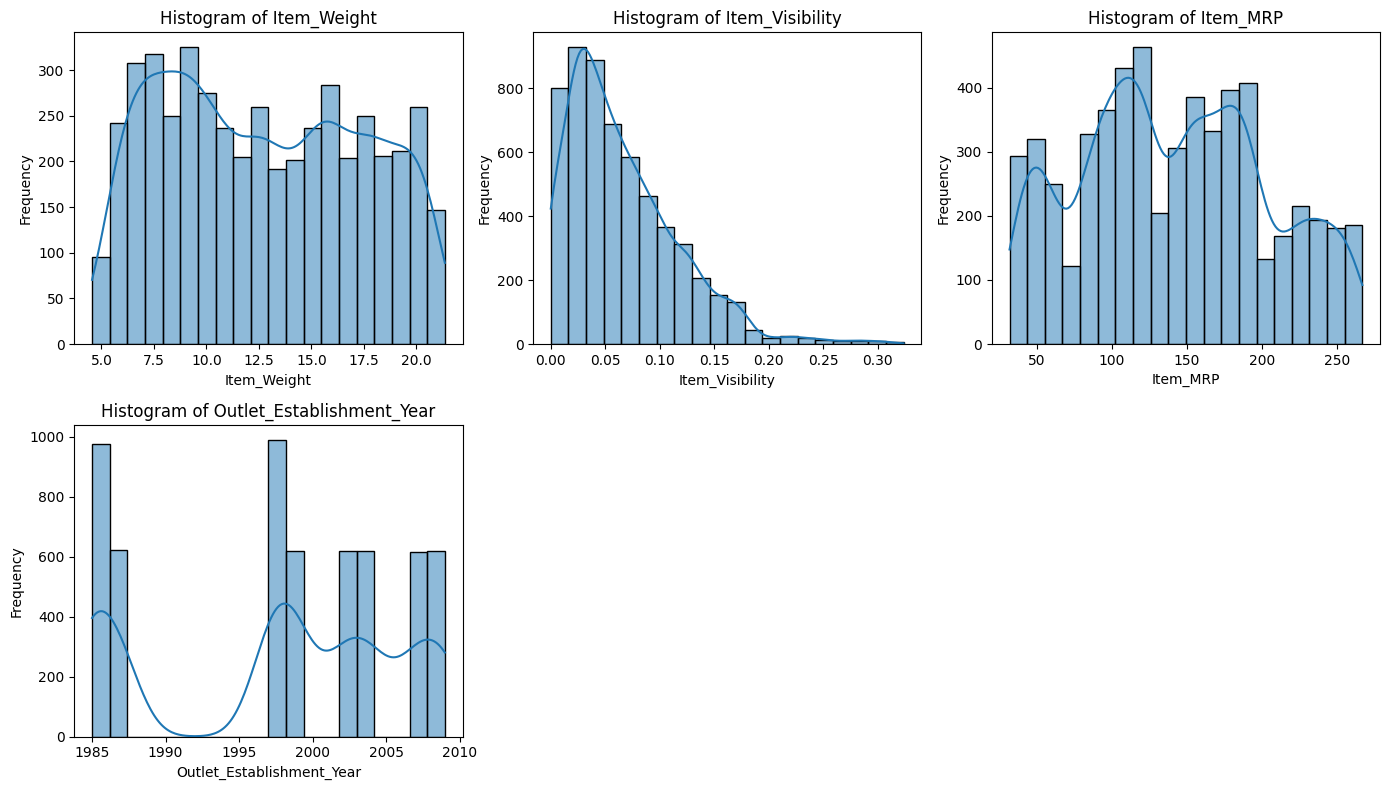

In [ ]:
test_use_columns = ['Item_Weight' ,'Item_Visibility' ,'Item_MRP' ,'Outlet_Establishment_Year']
plt.figure(figsize=(14 ,8))
for i ,column in enumerate(test_use_columns ,1) :
  plt.subplot(2 ,3 ,i)
  sns.histplot(test[column] ,bins=20 ,kde=True)
  plt.title(f'Histogram of {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<Figure size 1500x2500 with 0 Axes>

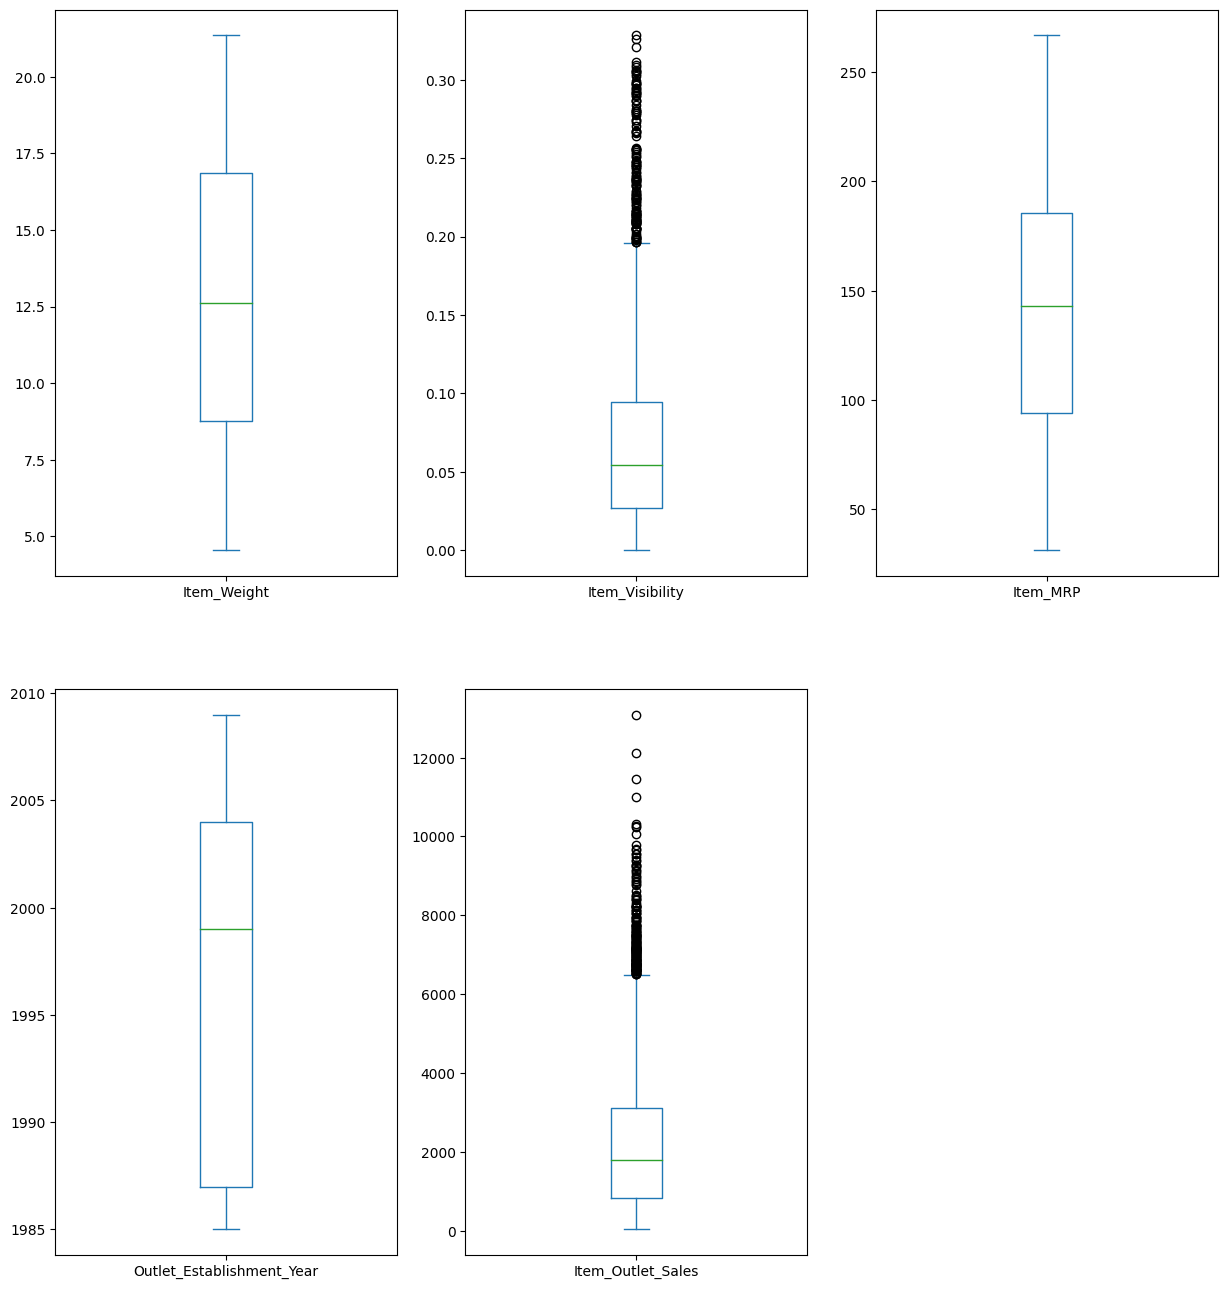

In [ ]:
plt.figure(figsize=(15, 25))
train.plot(kind="box", subplots=True, layout=(3, 3), figsize=(15, 25))
plt.show()

In [ ]:
plt.figure(figsize=(15, 25))
test.plot(kind="box", subplots=True, layout=(3, 3), figsize=(15, 25))
plt.show()

**觀察結果：**


*   Item_Weight、Item_MRP 和 Outlet_Establishment_Year 特徵中幾乎沒有異常值。
*   相反，Item_Visibility 和 Item_Outlet_Sales 函式中存在一些需要刪除的異常值。
*   訓練資料和測試資料幾乎具有相同的分佈

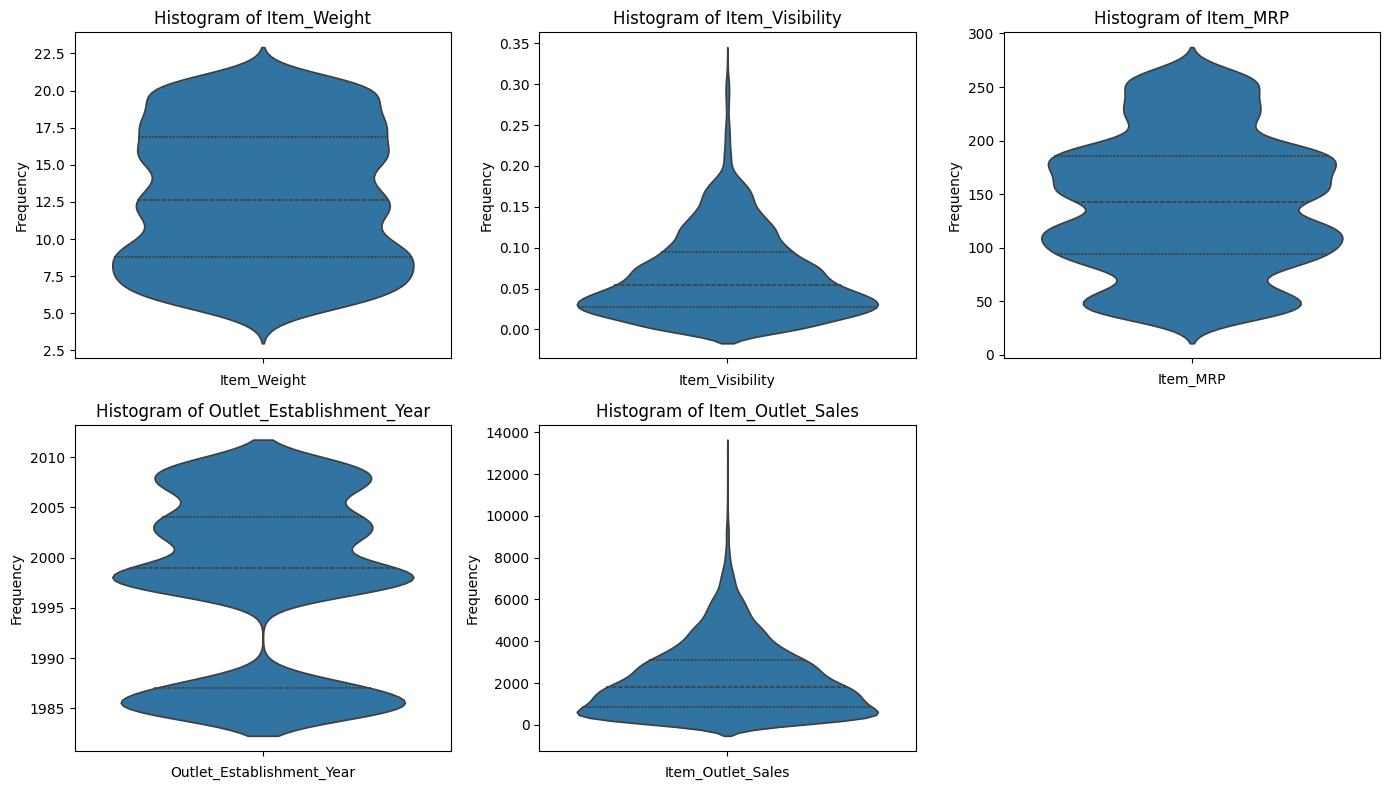

In [ ]:
plt.figure(figsize=(14 ,8))
for i ,column in enumerate(numeric_cols ,1) :
  plt.subplot(2 ,3 ,i)
  sns.violinplot(train[column] ,inner='quartile')
  plt.title(f'Histogram of {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

這些圖表證實了上述關於 Item_Visibility 和 Item_Outlet_Sales 特徵中異常值的觀察值。

**Categorical columns**

In [ ]:
categorical_cols = train.select_dtypes(include=['bool' ,'object']).columns
categorical_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

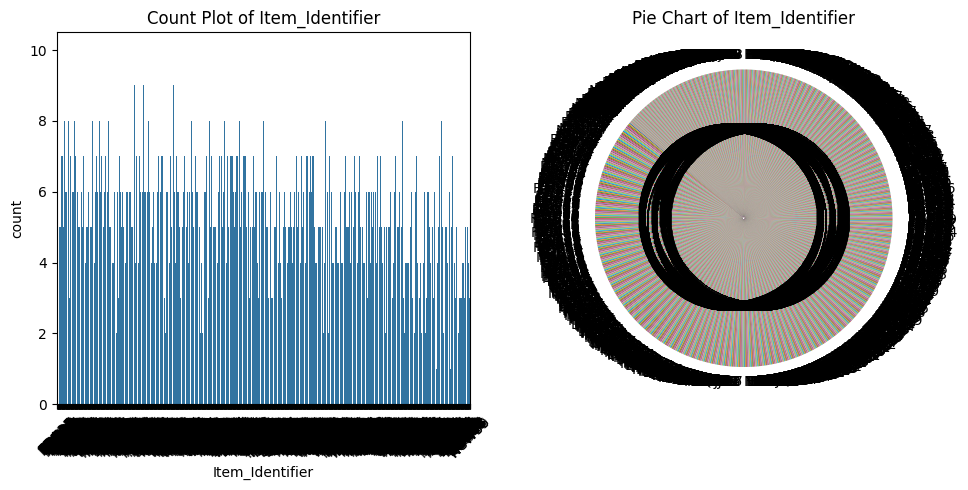

Item_Identifier
FDW13    10
DRN47     9
NCJ30     9
FDX31     9
FDW49     9
         ..
FDC23     1
DRG25     1
FDP15     1
DRF48     1
FDK57     1
Name: count, Length: 1559, dtype: int64


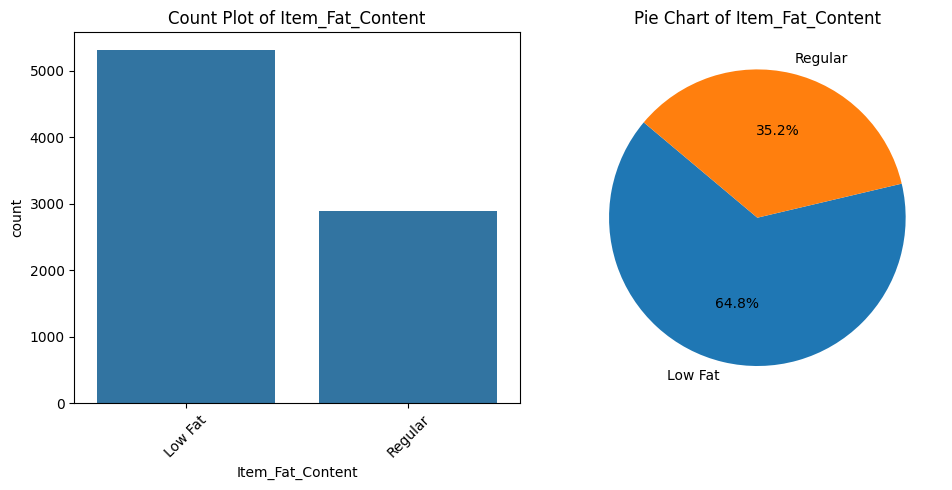

Item_Fat_Content
Low Fat    5309
Regular    2884
Name: count, dtype: int64


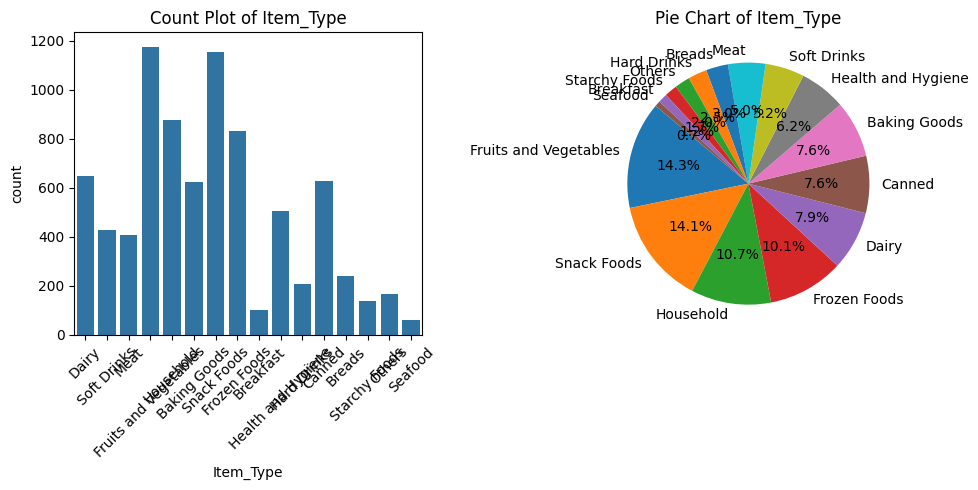

Item_Type
Fruits and Vegetables    1175
Snack Foods              1154
Household                 877
Frozen Foods              830
Dairy                     649
Canned                    626
Baking Goods              622
Health and Hygiene        507
Soft Drinks               428
Meat                      409
Breads                    242
Hard Drinks               207
Others                    167
Starchy Foods             139
Breakfast                 101
Seafood                    60
Name: count, dtype: int64


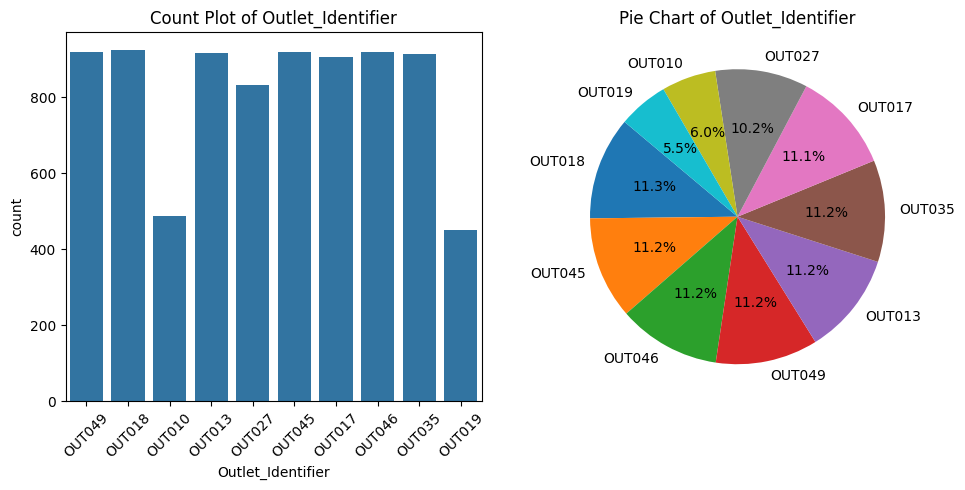

Outlet_Identifier
OUT018    925
OUT045    920
OUT046    920
OUT049    919
OUT013    917
OUT035    914
OUT017    907
OUT027    832
OUT010    488
OUT019    451
Name: count, dtype: int64


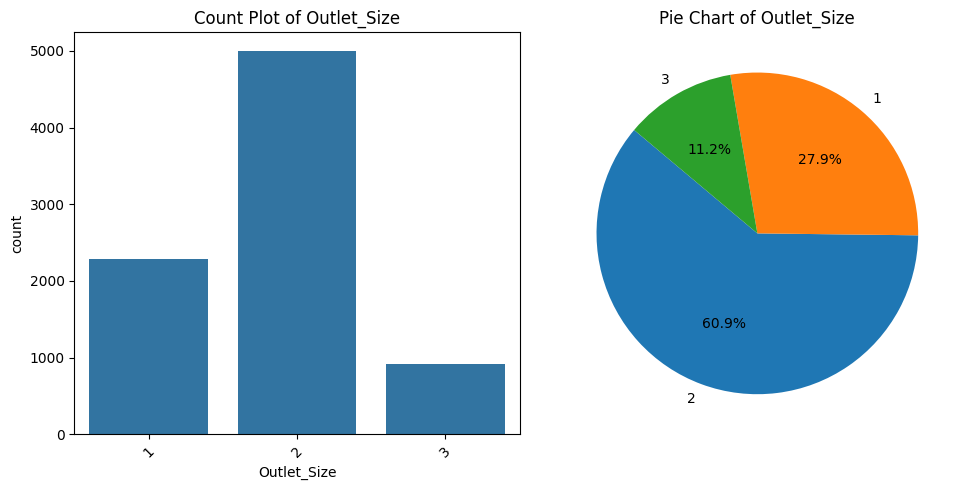

Outlet_Size
2    4991
1    2285
3     917
Name: count, dtype: int64


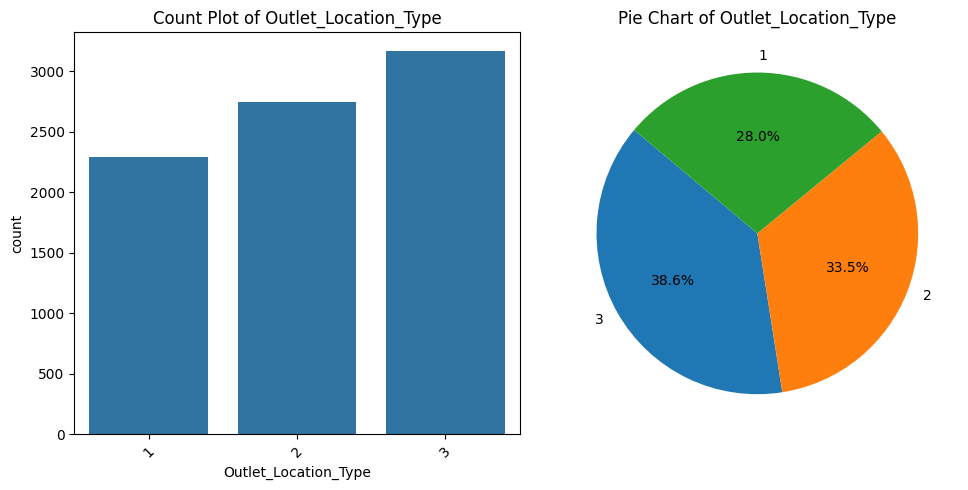

Outlet_Location_Type
3    3162
2    2741
1    2290
Name: count, dtype: int64


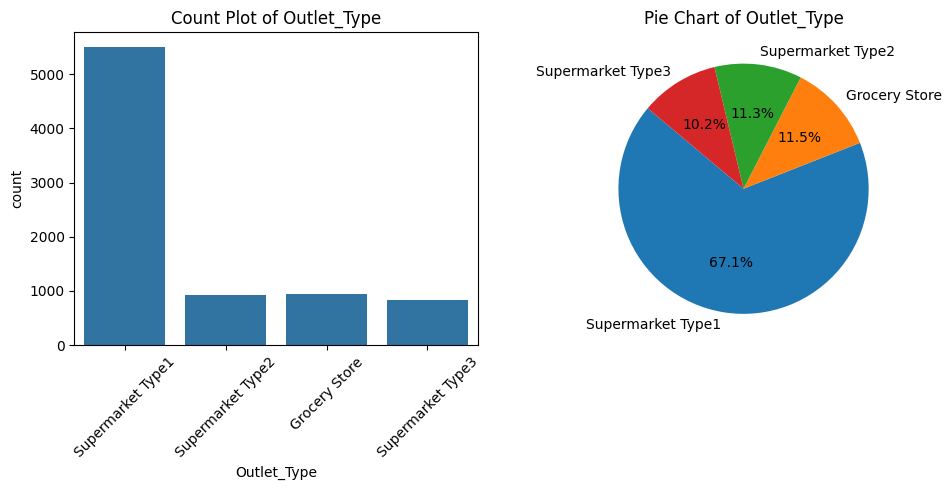

Outlet_Type
Supermarket Type1    5497
Grocery Store         939
Supermarket Type2     925
Supermarket Type3     832
Name: count, dtype: int64


In [ ]:
categorical_use_cols = ['Item_Identifier' ,'Item_Fat_Content' ,'Item_Type' ,'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
for col in categorical_use_cols:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=train)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    profile_counts = train[col].value_counts()
    plt.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart of {col}')
    plt.tight_layout()
    plt.show()
    print(train[col].value_counts())
    print('='*30)

**觀察結果:**

*   必須清理 Item_Fat_Content 列，因為存在一些輸入錯誤：
1.   'Low Fat', 'low fat' and 'LF' 應該是同一類別
2.   同樣 'Regular' and 'reg' 應該相同。
*   Item_type 功能中有 16 個不同的類別。我認為很多。可能在特徵工程部分我們可以嘗試將它們分組。例如分組：

1.   'Soft Drinks' and 'Hard Drinks' 歸類為'Drinks'
2.   'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' 歸類為'Foods'

*   對 Outlet_Location_Type 特徵進行編碼，我們只需提取最後一個字符:

1.   'Tier 1' ---> 1
2.   'Tier 2' ---> 2
3.   'Tier 3' ---> 3


# Bivariate Analysis

In [ ]:
target = "Item_Outlet_Sales"

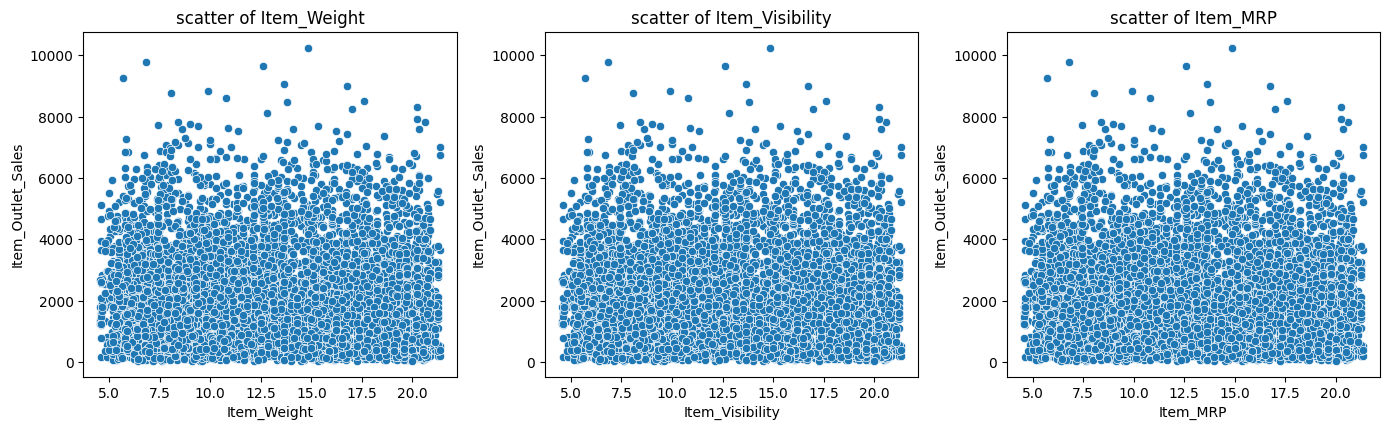

In [ ]:
ba_use_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
plt.figure(figsize=(14 ,8))
for i ,column in enumerate(ba_use_columns ,1) :
  plt.subplot(2 ,3 ,i)
  sns.scatterplot(data=train,x=col, y=target)
  plt.title(f'scatter of {column}')
  plt.xlabel(column)
plt.tight_layout()
plt.show()

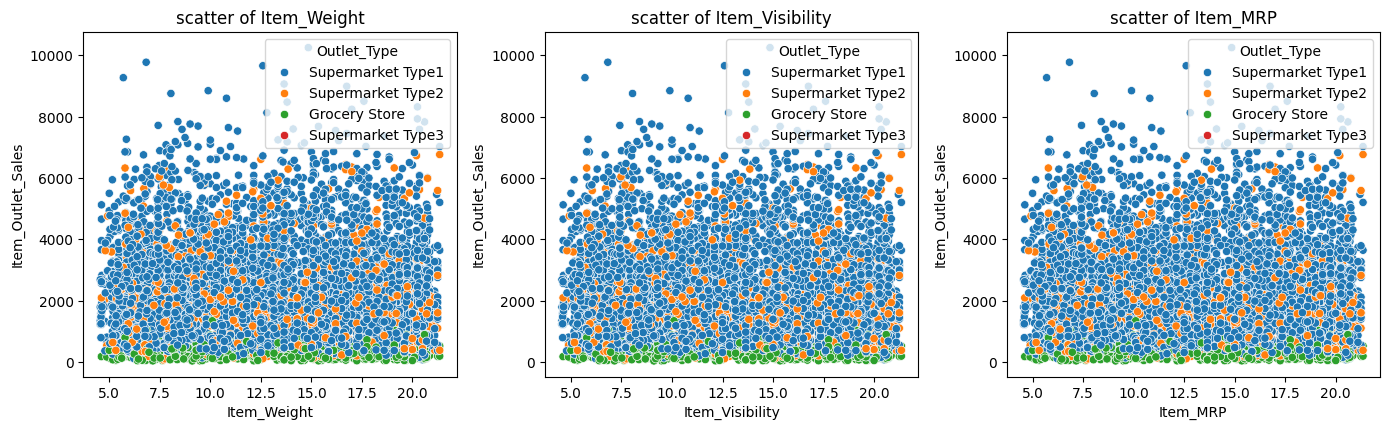

In [ ]:
ba_use_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
plt.figure(figsize=(14 ,8))
for i ,column in enumerate(ba_use_columns ,1) :
  plt.subplot(2 ,3 ,i)
  sns.scatterplot(data=train,x=col ,y=target ,hue='Outlet_Type')
  plt.title(f'scatter of {column}')
  plt.xlabel(column)
plt.tight_layout()
plt.show()

<Axes: >

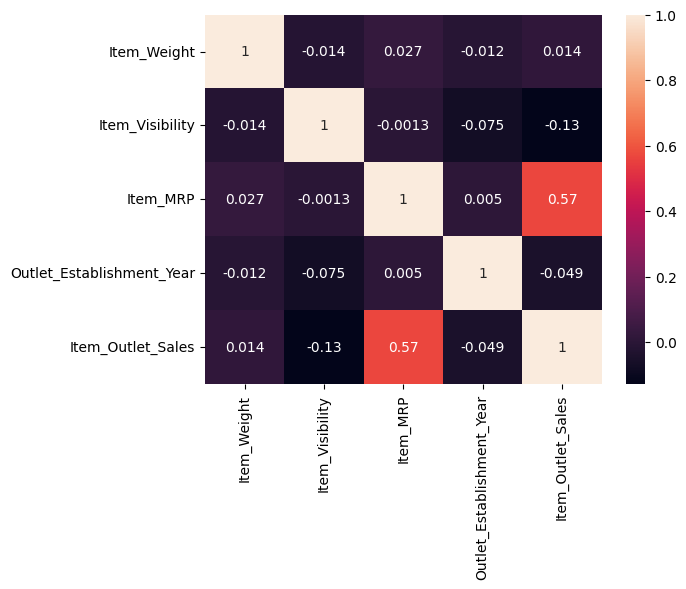

In [ ]:
train_numeric_corr = train[numeric_cols]
sns.heatmap(train_numeric_corr.corr(), annot=True)

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

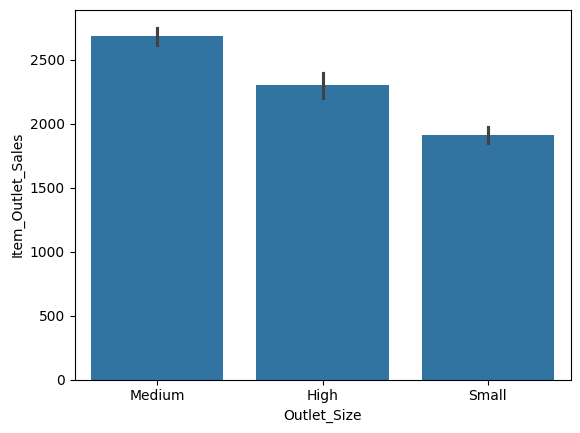

In [ ]:
sns.barplot(data=train, x='Outlet_Size', y=target)

# Missing Value Treatment


*   OutLet_Size是一個分類列，我們可以使用眾數來填入缺失值。
*   Item_weight 是一個數字列，經過視覺化，我們可以清楚地看到該特徵沒有異常值。因此我們可以用其平均值來取代缺失值。



In [ ]:
# for train
train['Outlet_Size'] = train.Outlet_Size.fillna(train.Outlet_Size.dropna().mode()[0]) # replace by the median after
train['Item_Weight'] = train.Item_Weight.fillna(train.Item_Weight.mean())

# for test
test['Outlet_Size'] = test.Outlet_Size.fillna(test.Outlet_Size.dropna().mode()[0]) # replace by the median after
test['Item_Weight'] = test.Item_Weight.fillna(test.Item_Weight.mean())

<Axes: >

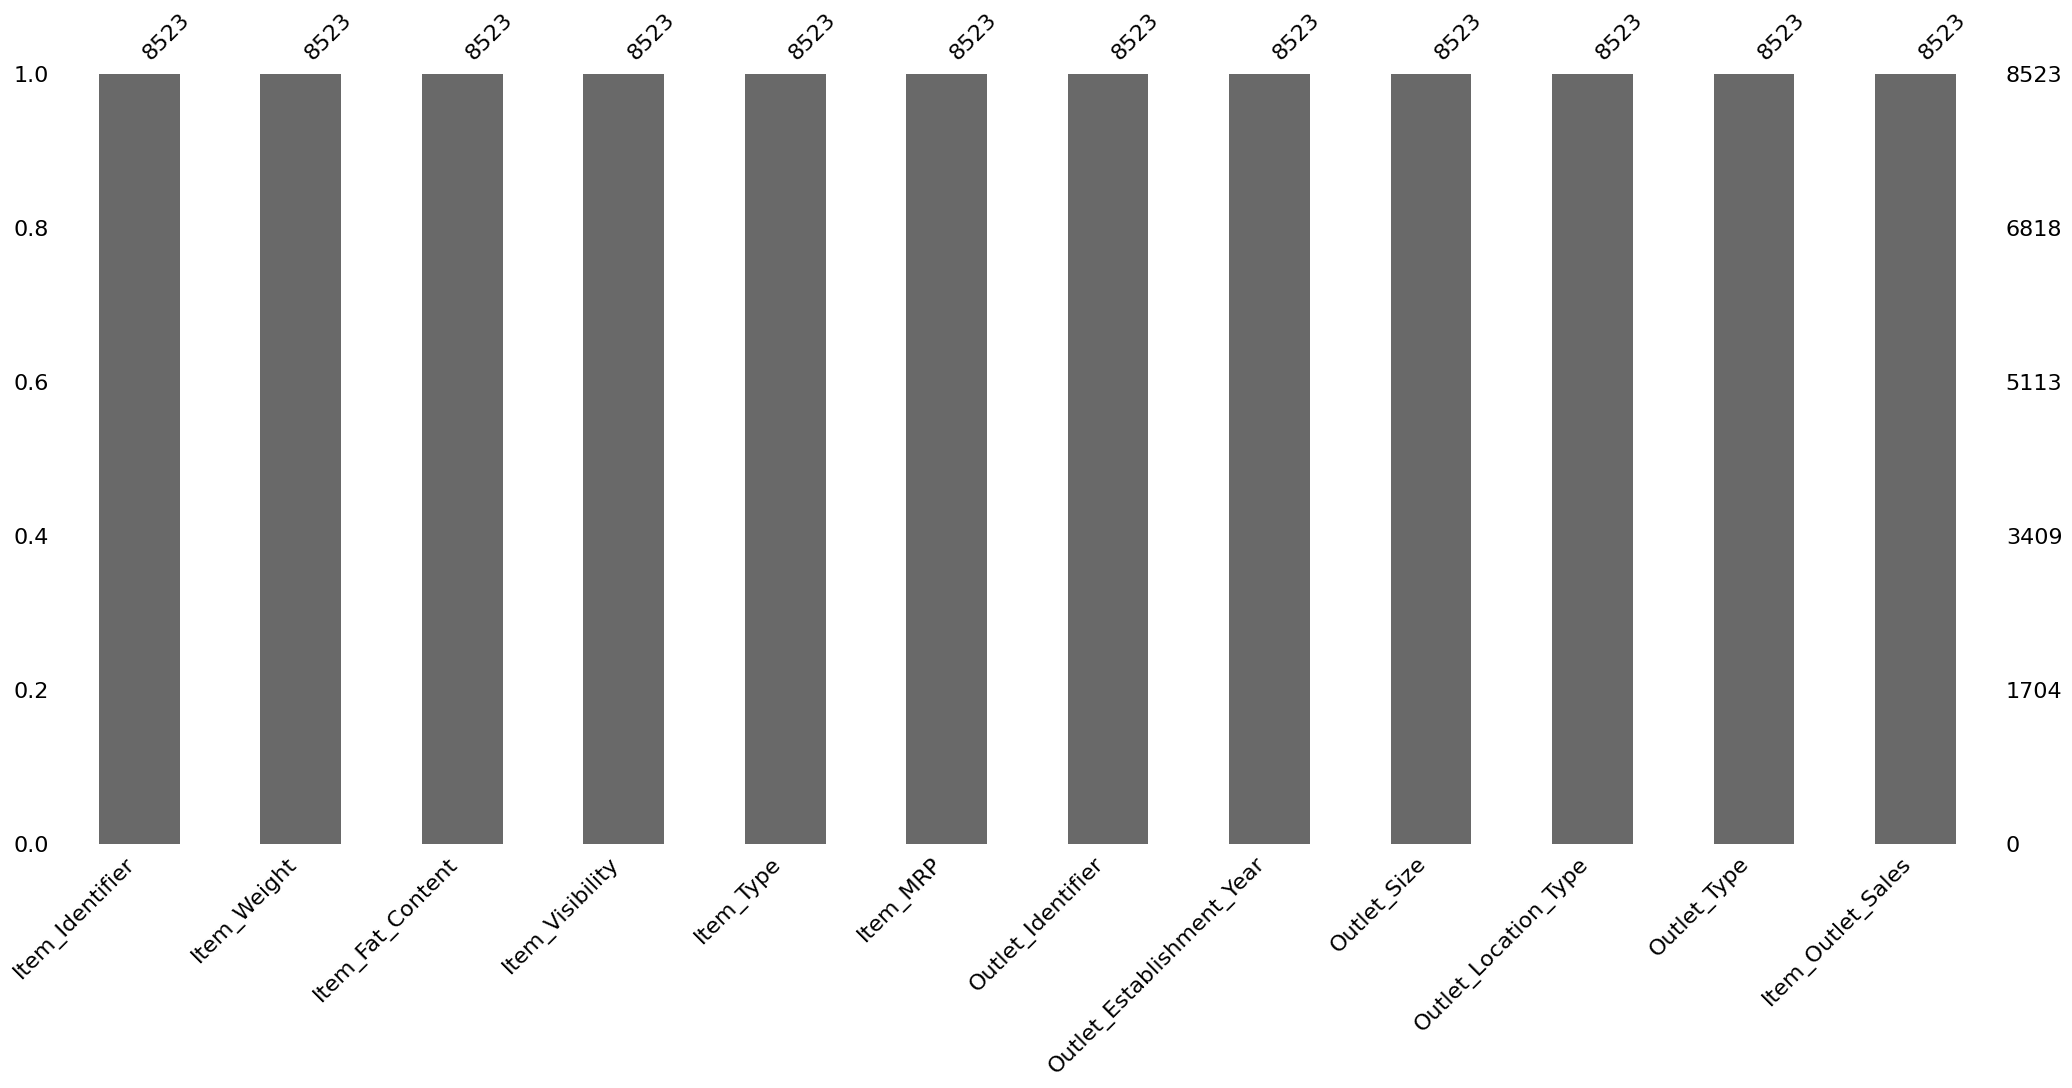

In [ ]:
msno.bar(train)

In [ ]:
msno.bar(test)

# Feature Engineering

In [ ]:
# function to detect outliers using the IQR method
def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


In [ ]:
# removing outliers using the above function
train = train[(train['Item_Visibility'] > lower) & (train['Item_Visibility'] < upper)] #train
test = test[(test['Item_Visibility'] > lower) & (test['Item_Visibility'] < upper)]     #test

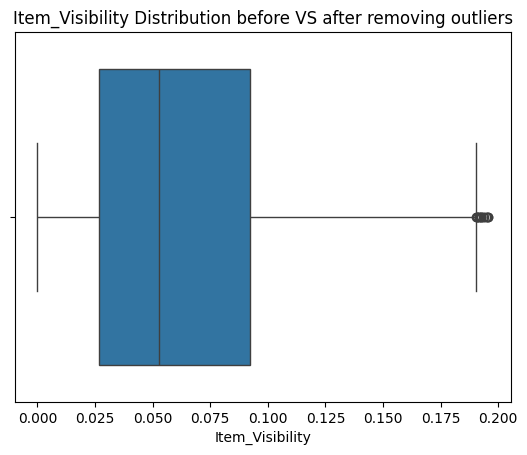

In [ ]:
sns.boxplot(x=train['Item_Visibility'])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


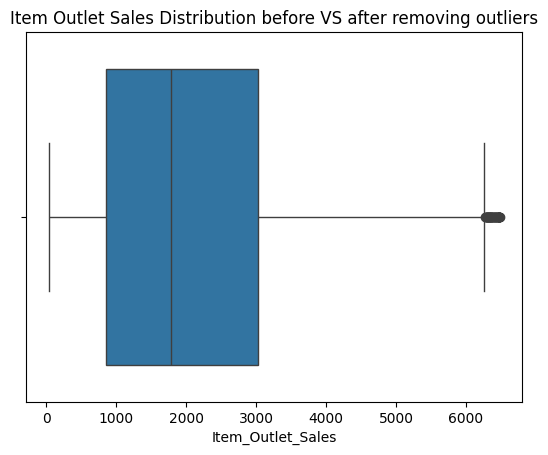

In [ ]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(train, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

# removing outliers using the same function
train = train[(train['Item_Outlet_Sales'] > lower) & (train['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train['Item_Outlet_Sales'])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

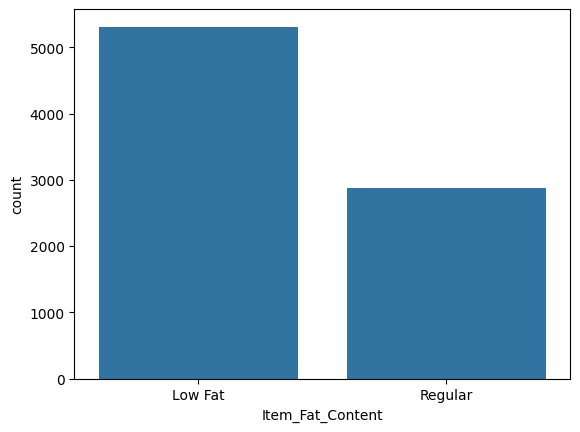

In [ ]:
# Let's correct the errors in the Item_Fat_Content column

train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat' : 'Low Fat',
                            'low fat' : "Low Fat",
                            'LF' : "Low Fat",
                            'Regular' : 'Regular',
                            'reg' : "Regular"
                          })

test['Item_Fat_Content'] = test['Item_Fat_Content'].map({'Low Fat' : 'Low Fat',
                          'low fat' : "Low Fat",
                          'LF' : "Low Fat",
                          'Regular' : 'Regular',
                          'reg' : "Regular"
                        })
sns.countplot(x=train['Item_Fat_Content']);

<Axes: xlabel='Outlet_Age', ylabel='count'>

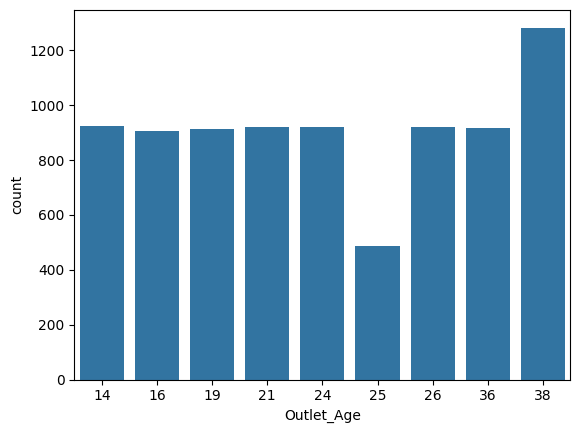

In [ ]:
# getting the amount of established years in new column and delete old column
train['Outlet_Age'] = 2023 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2023 - test['Outlet_Establishment_Year']

del train['Outlet_Establishment_Year']
del test['Outlet_Establishment_Year']

sns.countplot(x=train['Outlet_Age'])

# Encoding Categorical Variables

<Axes: xlabel='Outlet_Size', ylabel='count'>

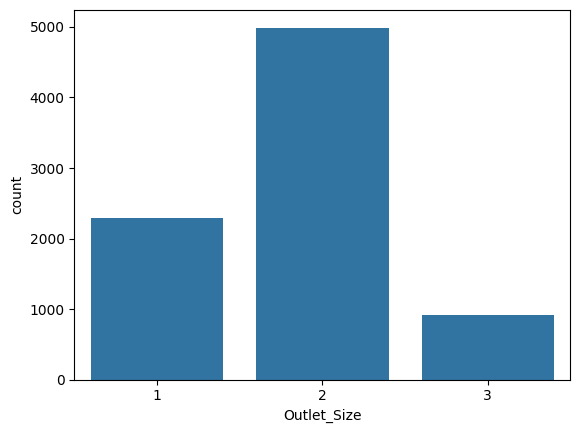

In [ ]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small' : 1, 'Medium' : 2, 'High' : 3}).astype(int)
test['Outlet_Size'] = test['Outlet_Size'].map({'Small' : 1, 'Medium' : 2, 'High' : 3}).astype(int)
sns.countplot(x=train['Outlet_Size'])

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

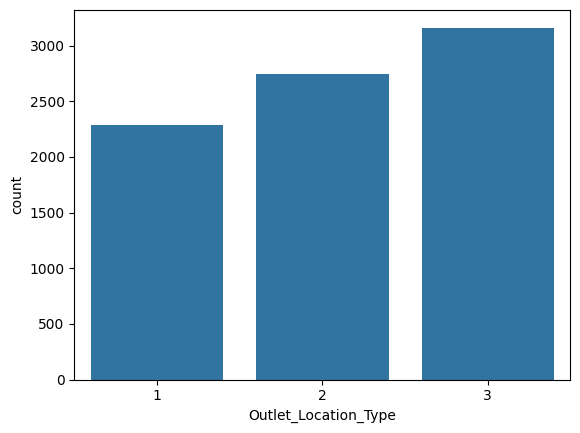

In [ ]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type
train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type']  = test['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train['Outlet_Location_Type'])

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

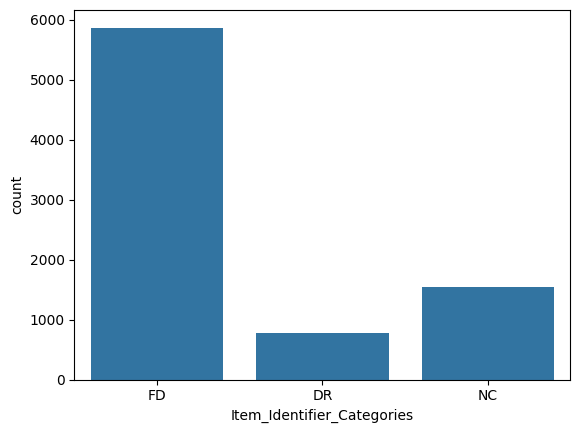

In [ ]:
train['Item_Identifier_Categories'] = train['Item_Identifier'].str[0:2] #.astype(int)
test['Item_Identifier_Categories']  = test['Item_Identifier'].str[0:2]

sns.countplot(x=train['Item_Identifier_Categories'])

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380,24,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,3,Supermarket Type2,443.4228,14,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700,24,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,Grocery Store,732.3800,25,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,3,3,Supermarket Type1,994.7052,36,NC


In [ ]:
# Label Encoder for Ordinate Data
encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type']

for feature in ordinal_features:
    train[feature] = encoder.fit_transform(train[feature])
    test[feature]  = encoder.fit_transform(test[feature])
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,2,1,1,3735.1380,24,FD
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,3,2,443.4228,14,DR
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,2,1,1,2097.2700,24,FD
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,0,732.3800,25,FD
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,3,3,1,994.7052,36,NC


In [ ]:
# One Hot Encoding for 'Item_Type' variable
train = pd.get_dummies(train, columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)
test  = pd.get_dummies(test,  columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,...,Item_Identifier_Categories_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,9.30,0,0.016047,249.8092,2,1,1,3735.1380,24,...,False,False,False,False,False,False,False,False,False,True
1,DRC01,5.92,1,0.019278,48.2692,2,3,2,443.4228,14,...,False,False,False,True,False,False,False,False,False,False
2,FDN15,17.50,0,0.016760,141.6180,2,1,1,2097.2700,24,...,False,False,False,False,False,False,False,False,False,True
3,FDX07,19.20,1,0.000000,182.0950,2,3,0,732.3800,25,...,False,False,False,False,False,False,False,False,False,False
4,NCD19,8.93,0,0.000000,53.8614,3,3,1,994.7052,36,...,True,True,False,False,False,False,False,False,False,False


# PreProcessing Data

In [ ]:
# Let's drop useless columns
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [ ]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [ ]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,...,Item_Identifier_Categories_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,2,1,1,24,False,False,...,False,False,False,False,False,False,False,False,False,True
1,5.92,1,0.019278,48.2692,2,3,2,14,False,False,...,False,False,False,True,False,False,False,False,False,False
2,17.50,0,0.016760,141.6180,2,1,1,24,False,False,...,False,False,False,False,False,False,False,False,False,True
3,19.20,1,0.000000,182.0950,2,3,0,25,False,False,...,False,False,False,False,False,False,False,False,False,False
4,8.93,0,0.000000,53.8614,3,3,1,36,False,False,...,True,True,False,False,False,False,False,False,False,False


In [ ]:
y.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


In [ ]:
# splitting into training set and test set 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

# Linear Regression

In [ ]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train ,y_train)

# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

Training score  : 0.5516657749034781
Test score      : 0.5471728591811283
RMSE  	         ----> 1021.5214420862889
R2 Score         ----> 0.5471728591811283


In [ ]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.5998209064648108
Test score      : 0.56601470878565


Ridge Regression or l2 Regularization

In [ ]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Ridge(alpha=7, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

# Predictions for Ridge on the test data
ridge_predictions = ridge_pipeline.predict(X_test)

# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

Training Score  : 0.5998213122987628
Test Score      : 0.5662904189776015
Ridge RMSE  	         ----> 999.7255019674704
Ridge R2 Score         ----> 0.5662904189776015


Lasso Regression or l1 Regularization

In [ ]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Training score  : 0.5997864842164851
Test score      : 0.566810150811661
Lasso RMSE  	         ----> 999.1263165378849
Lasso R2 Score         ----> 0.566810150811661


Ridge and Lasso gives better results than LinearRegression.

ElasticNet Regression

In [ ]:
# Pipeline steps
steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True))  # 使用 ElasticNet 模型
]

elasticnet_pipeline = Pipeline(steps)

# 模型訓練
elasticnet_pipeline.fit(X_train, y_train)

# 訓練與測試集評估
print('Training Score  : {}'.format(elasticnet_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(elasticnet_pipeline.score(X_test, y_test)))

# 預測測試集數據
elasticnet_predictions = elasticnet_pipeline.predict(X_test)

# 評估
elasticnet_mse = mean_squared_error(y_test, elasticnet_predictions)
elasticnet_rmse = math.sqrt(elasticnet_mse)
elasticnet_r2 = r2_score(y_test, elasticnet_predictions)

# 輸出評估結果
print('ElasticNet RMSE          ----> {}'.format(elasticnet_rmse))
print('ElasticNet R2 Score      ----> {}'.format(elasticnet_r2))

Training Score  : 0.5466020030299321
Test Score      : 0.5193604736633859
ElasticNet RMSE          ----> 1052.42463165666
ElasticNet R2 Score      ----> 0.5193604736633859


# RandomForest

In [ ]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

# Predictions for XGBoost on the test data
rand_forest_predictions = rand_forest_model.predict(X_test)

print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

Training score  : 0.9347666660356954
Test score      : 0.520517954771466
RandomForest RMSE  	       ----> 1051.1566378236232
RandomForest R2 Score       ----> 0.520517954771466


The gap between the training score and the test score is huge so RandomForest is overfitting the data. We can handle this issue with hyperparameter tuning.

# XGBoost

In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost Training score  : 0.855475128396549
XGBoost Test score      : 0.4740711163368567
XGBoost RMSE  	   ----> 1100.892147232883
XGBoost R2 Score   ----> 0.4740711163368567


XGBoost is also overfitting the data. We'll try after to tune the hyperparameters for XGBoost and see how the model performs.

# Final Predictions On The Test Dataset

In [ ]:
# Final predictions on test data using Lasso
final_test_preds = lasso_pipeline.predict(test)

# Saving The Final Model

In [ ]:
# Saving model to pickle file
with open("BigMart_Sales_Model.pkl", "wb") as file: # file is a variable for storing the newly created file.
    pickle.dump(lasso_pipeline, file)              # Dump function is used to write the object into the created file in byte format.

In [ ]:
import pickle

# 從 pickle 文件中讀取模型
with open("BigMart_Sales_Model.pkl", "rb") as file:  # 'rb' 代表以二進制讀取模式打開
    loaded_model = pickle.load(file)

# 使用訓練數據重新訓練模型
loaded_model.fit(X_train, y_train)

print('Training score  : {}'    .format(loaded_model.score(X_train, y_train)))
print('Test score      : {}'    .format(loaded_model.score(X_test, y_test)))

# Predictions for Lasso on the testset
lasso_predictions = loaded_model.predict(X_test)

# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Training score  : 0.5997864842164851
Test score      : 0.566810150811661
Lasso RMSE  	         ----> 999.1263165378849
Lasso R2 Score         ----> 0.566810150811661


# Reference

https://medium.com/@saibhargavkarnati/big-mart-sales-prediction-using-the-xgboost-regressor-ml-78dac201cab8

https://www.kaggle.com/code/waalbannyantudre/bigmart-sales-prediction-project